In [24]:
# Import Python Packages
# !pip install -U kaleido
!pip install kaleido

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

import plotly.express as px
import plotly.io as pio
px.defaults.width = 700
px.defaults.height = 500

plt.style.use(['seaborn-talk','dark_background',])
# pio.templates.default='plotly_dark'

In [25]:
# Import data and export to csv file
king = pd.read_csv('data/kings_county_data.csv')
display(king.head(2))
# Additional setup for Python figs
king.rename({'long':'lon'},axis=1,inplace=True)
king['waterfront'] = king['waterfront'].astype(str)
king.info()

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0         NaN   0.0  ...      7        1180            0.0   
1      7242     2.0         0.0   0.0  ...      7        2170          400.0   

  yr_built  yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0     1955           0.0    98178  47.5112 -122.257           1340        5650  
1     1951        1991.0    98125  47.7210 -122.319           1690        7639  

[2 rows x 21 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     21597 non-null  object 
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  lon   

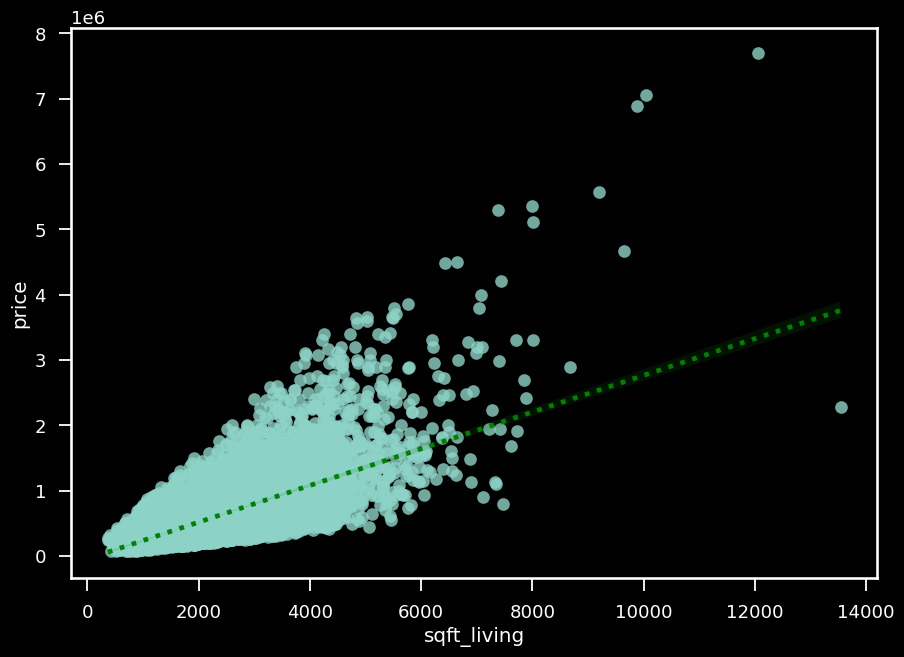

In [26]:
# Scatterplot
# Seaborn
sns.regplot(data=king, x='sqft_living',y='price',
            line_kws={'color':'green',"ls":':'});
# Plotly
px.scatter(king, x='sqft_living',y='price',trendline='ols',
           trendline_color_override='green')


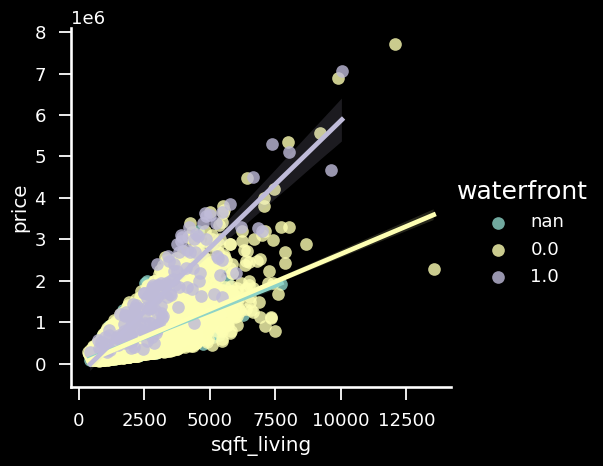

In [27]:
# Python Answer - Seaborn
sns.lmplot(data=king, x='sqft_living',y='price',hue='waterfront');

# Python Answer - Plotly
px.scatter(king, x='sqft_living',y='price',color='waterfront',trendline='ols',
           trendline_color_override='green')


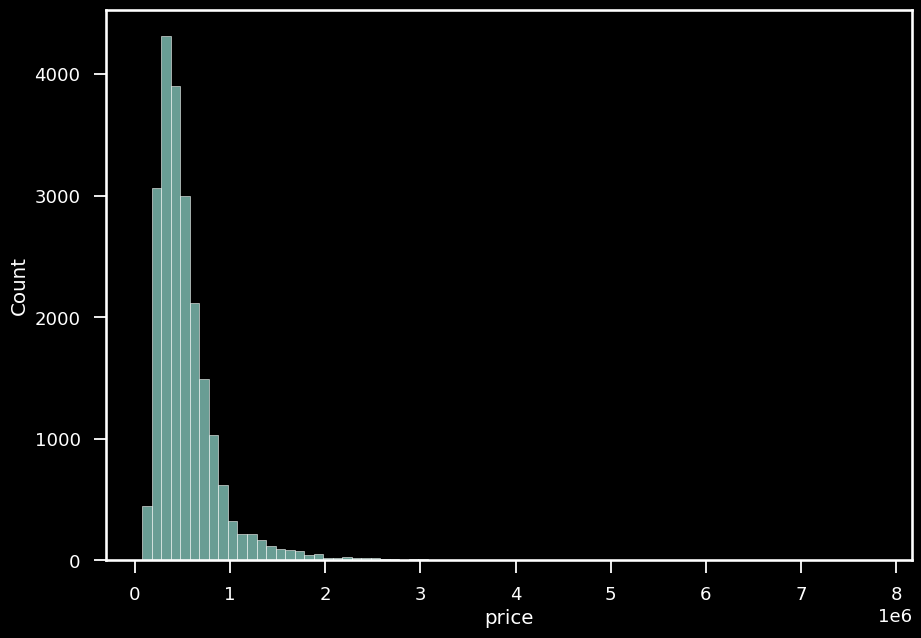

In [28]:
# Python Answer - Seaborn
sns.histplot(king,x='price',binwidth=100_000);

# Python Answer - Plotly

# must calculate n_bins
n_bins=77
king['price'].max()/n_bins
px.histogram(king,x='price',nbins=n_bins,width=800)

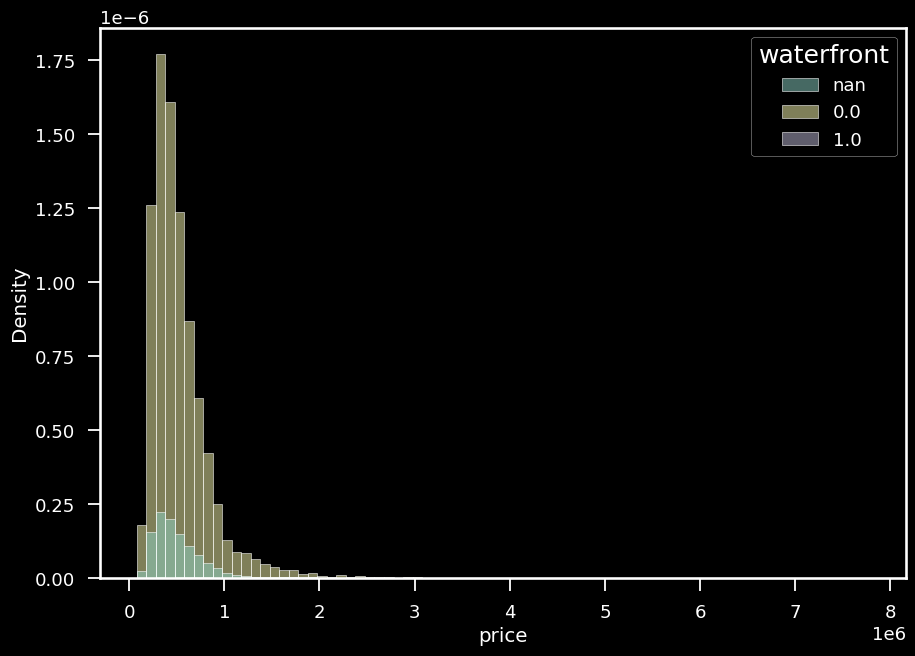

In [29]:
# Python Answer - Seaborn
sns.histplot(king, x='price', binwidth=100_000,
             hue='waterfront', stat='density');

# Python Answer - Plotly
px.histogram(king,x='price',color='waterfront',nbins=n_bins,
             width=800,barmode='overlay')

In [31]:
import requests,json
url ='https://opendata.arcgis.com/datasets/e6c555c6ae7542b2bdec92485892b6e6_113.geojson'
content = requests.get(url).json()
content.keys()

dict_keys(['type', 'name', 'crs', 'features'])

In [32]:
zipcodes_df = pd.read_csv('data/zipcodes.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'data/zipcodes.csv'

In [ ]:
# Took a public data file containing the shapes of zipcodes in King County using latitude/longitude coordinates
# geojson file source: https://data.seattle.gov/dataset/Zip-Codes/dk58-w4ct

# Parsed just the zipcodes in our source dataset from the public geojson file 
# into an updated json with just the necessary data for mapping
# inspiration from: https://towardsdatascience.com/visualizing-data-at-the-zip-code-level-with-folium-d07ac983db20

import json
with open('data/kc_zipcode_map.geojson', 'r') as jsonFile:
    kczipcodes = json.load(jsonFile)

geozips = []
for i in range(len(kczipcodes['features'])):
    if kczipcodes['features'][i]['properties']['ZIP'] in list(zipcodes_df['zipcode'].unique()):
        geozips.append(kczipcodes['features'][i])

new_json = dict.fromkeys(['type', 'features'])
new_json['type'] = 'FeatureCollection'
new_json['features'] = geozips

open('data/updated_kc_zipcode_map.json', 'w').write(
        json.dumps(new_json, sort_keys=True, indent=4, separators=(',', ': ')));

In [ ]:
# Checking the format of the new json file to find what I can map to the zipcodes_df
with open('data/updated_kc_zipcode_map.json', 'r') as f:
    kc_geojson = json.load(f)
#kc_geojson['features'][0]

In [ ]:
# Create a string column with formatted price to put in visualization
zipcodes_df['$price'] = zipcodes_df['price'].apply(lambda x: '${:,}'.format(x))

def zipcodes_map(df, color, hoverdata=None, title=None, labels=None):
    '''
    Parameters:
    df - pd.Dataframe, main data to read
    color - str, column name in df to visualize
    hoverdata - list, column names to display on map
    labels - optional dict, {hoverdata: display name} to display more intuitive names
    title - optional str, title for map
    
    Returns:
    Choropleth map
    '''
    fig = px.choropleth_mapbox(data_frame=df, locations='zipcode', center={'lat': 47.47, 'lon': -121.84}, 
                               color=color, color_continuous_scale='dense',
                               geojson=kc_geojson, featureidkey='properties.ZIP', 
                               hover_data=hoverdata, labels=labels,
                               title=title, height=700, width=900, opacity=.7)
    fig.update_layout(mapbox_style='carto-positron')
    fig.update_geos(fitbounds='locations', visible=False)
    fig.write_image((f'images/zipmap_{color}.png'))
    fig.show()

In [ ]:
hoverdata = ['$price', 'sqft_living', 'sqft_lot', 'yr_built']
labels = {'$price': 'Sale Price', 'sqft_living': 'Living Space (sqft)', 
          'sqft_lot': 'Lot Size (sqft)', 'yr_built': 'Year Built',
         'price': 'Sale Price ($)'}
mean_title = 'Average House Sale Price($), King County'
zipcodes_map(zipcodes_df, 'price', hoverdata=hoverdata, title=mean_title, labels=labels)